PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: True
<class 'numpy.ndarray'>


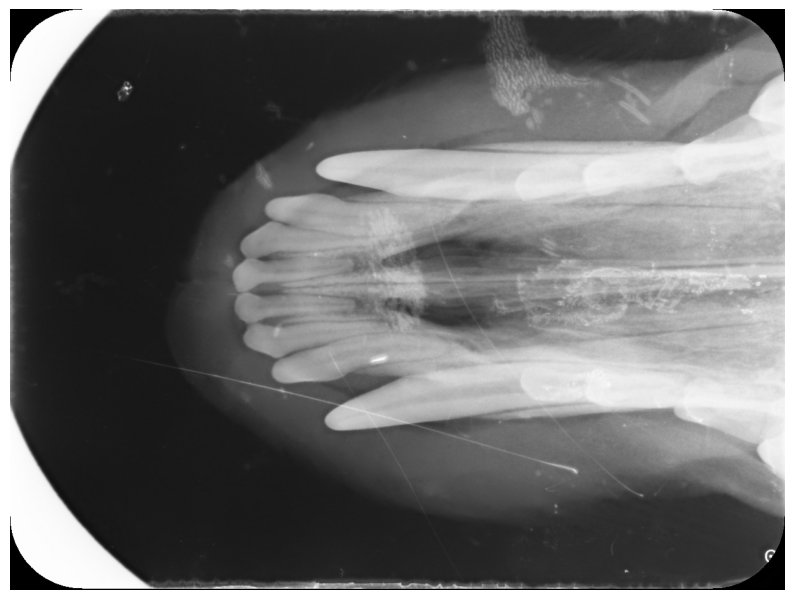

hiiiiii 41


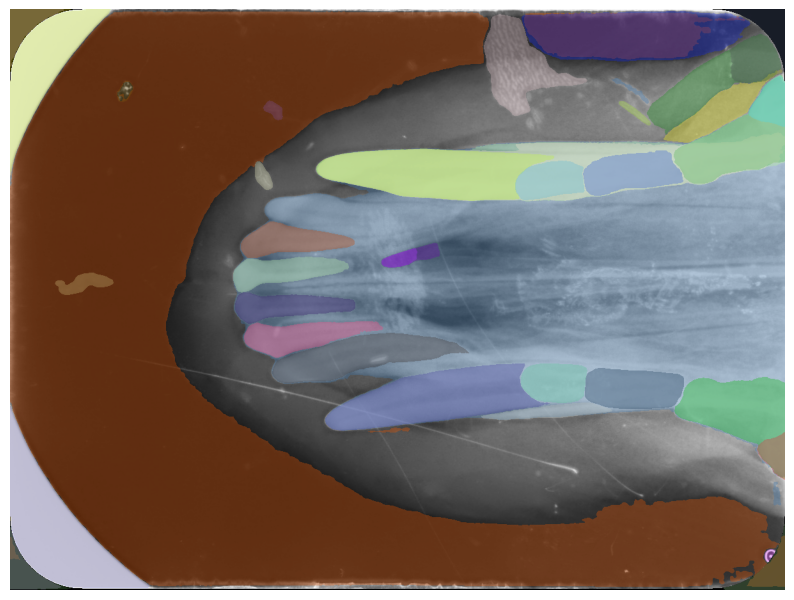

In [2]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


filepath='S:\\Hi5\Accesia\\ExportedXrays\\1.jpg'        
image = cv2.imread(filepath)  #Try houses.jpg or neurons.jpg
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(type(image))

#tensor_a = torch.from_numpy(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()


sam_checkpoint = "S:\Hi5\Accesia\SegnmentAnythingModel\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=25,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=150,  # Requires open-cv to run post-processing
)

masks1 = mask_generator_.generate(image)

print("hiiiiii",len(masks1))


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks1)
plt.axis('off')
plt.show() 



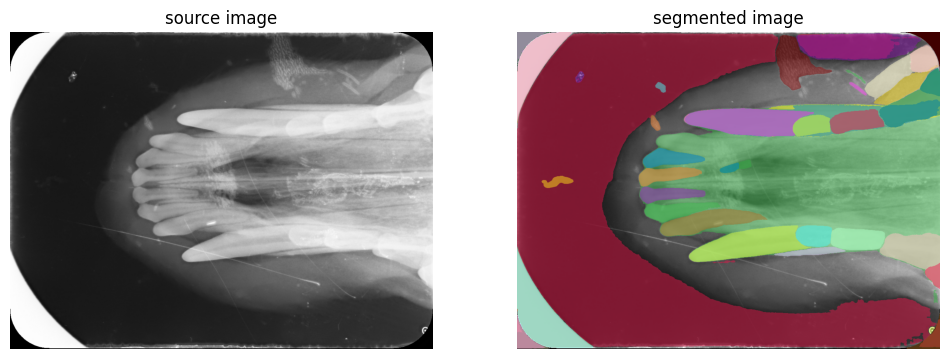

In [3]:

import supervision as sv

mask_annotator = sv.MaskAnnotator()


detections = sv.Detections.from_sam(sam_result=masks1)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [3]:
print(masks1[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [4]:
masks = [
    mask['segmentation']
    for mask
    in sorted(masks1, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

ValueError: The number of images exceeds the grid size. Please increase the grid size or reduce the number of images.

In [5]:
mask_predictor = SamPredictor(sam)

In [6]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [7]:
IS_COLAB = True

# if IS_COLAB:
#     from google.colab import output
#     output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(filepath)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [13]:
widget.bboxes

[{'x': 341, 'y': 330, 'width': 210, 'height': 56, 'label': ''}]

In [14]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']])

In [15]:
import cv2
import numpy as np
import supervision as sv

# image_bgr = cv2.imread(IMAGE_PATH)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True)

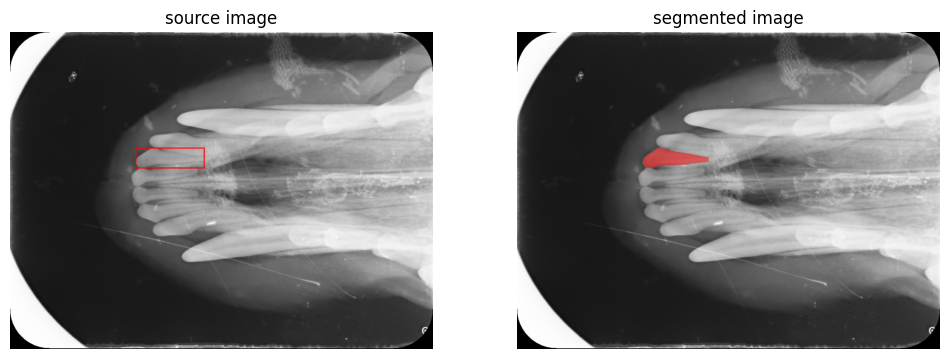

In [16]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

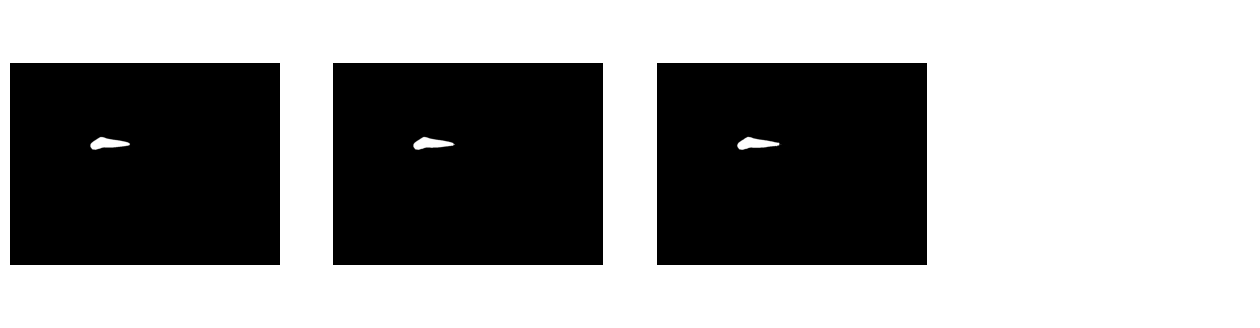

In [17]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)